In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [37]:
features = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_111M.arrow")
# features = load_from_disk("../outputs/development_fmri_brainlm_a424_111M.arrow")
y_genderclass = np.array(features['Gender'])
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

## Prediction with functional connectivity on adult vs child

Since the atlas covers cerebellum, this should overfit very easily

Overall Accuracy: 0.9224137931034483
              precision    recall  f1-score   support

       adult       0.86      0.76      0.81        25
       child       0.94      0.97      0.95        91

    accuracy                           0.92       116
   macro avg       0.90      0.86      0.88       116
weighted avg       0.92      0.92      0.92       116



Text(50.722222222222214, 0.5, 'Observed')

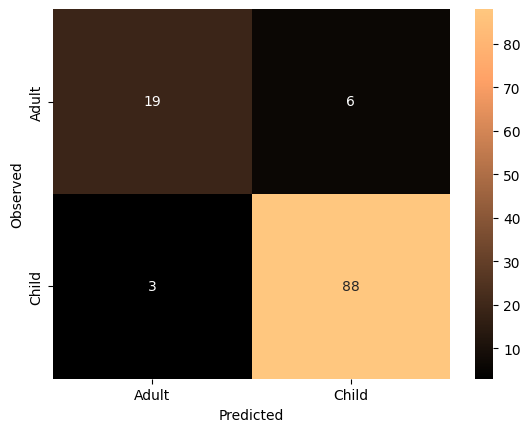

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    fc, y_ageclass, stratify=y_ageclass, random_state=42
)
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=5)), 
    ('svc', SVC(C=1000))
])
cv = StratifiedKFold(n_splits=3)
scores = cross_val_score(pipe, X_train, y_train, cv=cv)
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv)

overall_acc = accuracy_score(y_pred=y_pred, y_true=y_train)
overall_cr = classification_report(y_pred=y_pred, y_true=y_train)
overall_cm = confusion_matrix(y_pred=y_pred, y_true=y_train)
print('Overall Accuracy:', overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper', annot=cmdf)
plt.xlabel('Predicted')
plt.ylabel('Observed')

## Prediction with CLS token on child vs adult

Overall Accuracy: 0.5086206896551724
              precision    recall  f1-score   support

       adult       0.17      0.32      0.22        25
       child       0.75      0.56      0.64        91

    accuracy                           0.51       116
   macro avg       0.46      0.44      0.43       116
weighted avg       0.62      0.51      0.55       116



Text(50.722222222222214, 0.5, 'Observed')

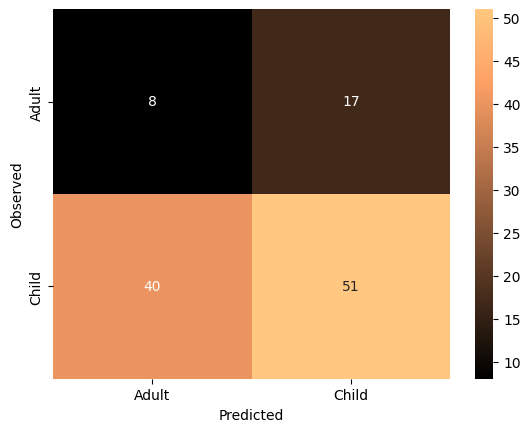

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    cls_token, y_ageclass, stratify=y_ageclass, random_state=42
)
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=5)), 
    ('svc', SVC(C=1, class_weight='balanced'))
])
cv = StratifiedKFold(n_splits=3)
scores = cross_val_score(pipe, X_train, y_train, cv=cv)
y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv)

overall_acc = accuracy_score(y_pred=y_pred, y_true=y_train)
overall_cr = classification_report(y_pred=y_pred, y_true=y_train)
overall_cm = confusion_matrix(y_pred=y_pred, y_true=y_train)
print('Overall Accuracy:', overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper', annot=cmdf)
plt.xlabel('Predicted')
plt.ylabel('Observed')